# Learing pipeline

Miguel Xochicale [@mxochicale](https://github.com/mxochicale)  
Feb2022; March2022 


## 1 Introduction
This notebook presents prototypes to pre-process echocardiography datasets with the use of pytorch features. 

### 1.1 Running notebook

1. Go to echocardiography repository path: `$HOME/repositories/echocardiography/`
2. Open echocardiography repo in pycharm and in the terminal type:
    ```
    git checkout master # or the branch
    git pull # to bring a local branch up-to-date with its remote version
    ```
3. Launch Notebook server
    Go to you repository path: `cd $HOME/repositories/echocardiography/scripts/dataloaders` and type in the pycharm terminal:
    ```
    conda activate rt-ai-echo-VE 
    jupyter notebook
    ```
    which will open your web-browser.
    
    
### 1.2 References
* "Proposed Regulatory Framework for Modifications to Artificial Intelligence/Machine Learning (AI/ML)-Based Software as a Medical Device (SaMD) - Discussion Paper and Request for Feedback". https://www.fda.gov/media/122535/download 
* Gomez A. et al. 2021 https://github.com/vital-ultrasound/lung/blob/main/multiclass_pytorch/datasets/LUSVideoDataset.py 




## 2. Jupyter Notebook

### 2.1 Setting imports and datasets paths

In [1]:
import os
import sys
import argparse
import yaml
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from IPython.display import HTML #to be used with HTML(animation.ArtistAnimation().to_jshtml())
from tqdm import tqdm

import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from typing import Dict, List, Tuple

from torch.utils.data import DataLoader
import torch.utils.data as Data
from torchinfo import summary
from torchvision import transforms, utils, models

from source.dataloaders.EchocardiographicVideoDataset import EchoClassesDataset
from source.models.learning_misc import train_loop, test_loop, BasicCNNClassifier, TestNet
from source.helpers.various import concatenating_YAML_via_tags, plot_dataset_classes

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]

CONFIG_FILES_PATH= 'repositories/echocardiography/scripts/config_files//users_paths_files'
YML_FILE =  'config_users_paths_files_username_' + USERNAME + '.yml'
FULL_PATH_FOR_YML_FILE = os.path.join(HOME_PATH, CONFIG_FILES_PATH, YML_FILE)

yaml.add_constructor('!join', concatenating_YAML_via_tags)  ## register the tag handler

with open(FULL_PATH_FOR_YML_FILE, 'r') as yml:
    config = yaml.load(yml, Loader=yaml.FullLoader)
    
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)    


PyTorch Version:  1.9.0
Torchvision Version:  0.10.0a0


### 2.2 Setting variables and loading datasets using pytorch dataloader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Defining transforms that apply to the entire dataset.
# These transforms are not augmentation.
if config['use_pretransform_image_size']:
    pretransform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size=config['pretransform_im_size']),
        transforms.ToTensor(),
    ])
else:
    pretransform = None

# These transforms have random parameters changing at each epoch.
if config['use_train_augmentation']:
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),  # in degrees
        transforms.RandomEqualize(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(), 
    ])
else:
    transform = None
    
# These transforms have random parameters changing at each epoch.
if config['use_validation_augmentation']:
    val_transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),  # in degrees
    #transforms.RandomEqualize(p=0.5),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #transforms.ToTensor(), 
    ])
else:
    transform = None


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 80% of total datasets
train_dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list_train'],
    participant_path_json_list=config['participant_path_json_list_train'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=train_transform,
    use_tmp_storage=True,
    )

#### 20% of total datasets
validation_dataset = EchoClassesDataset(
    main_data_path=config['main_data_path'],
    participant_videos_list=config['participant_videos_list_validation'],
    participant_path_json_list=config['participant_path_json_list_validation'],
    crop_bounds_for_us_image=config['crop_bounds_for_us_image'],
    number_of_frames_per_segment_in_a_clip=config['number_of_frames_per_segment_in_a_clip'],
    sliding_window_length_in_percentage_of_frames_per_segment=config['sliding_window_length_in_percentage_of_frames_per_segment'],
    device=device,
    max_background_duration_in_secs=config['max_background_duration_in_secs'],
    pretransform=pretransform,
    transform=val_transform,
    use_tmp_storage=True,
    )


## Spliting train_dataset into train_set and test_set
Ntdt = train_dataset.__len__()
ntraining = 0.8

Ntrain=round(Ntdt*ntraining)
Ntest = round(Ntdt - (Ntdt*ntraining))
print(Ntrain, Ntest, Ntrain+Ntest)
train_set, test_set = torch.utils.data.random_split(train_dataset, [Ntrain, Ntest])



[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-074/T3/01NVb-003-074-3-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T1/01NVb-003-077-1-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T2/01NVb-003-077-2-4CV.json (empty). Removing from list
[ERROR] [EchoClassesDataset.__init__()] Error reading /home/mx19/datasets/vital-us/echocardiography/videos-echo-annotated/01NVb-003-077/T3/01NVb-003-077-3-4CV.json (empty). Removing from list
58 14 72


### 2.3 Plotting Class Distribution


{'BKGR': 31, '4CV': 27}
{'BKGR': 8, '4CV': 8}


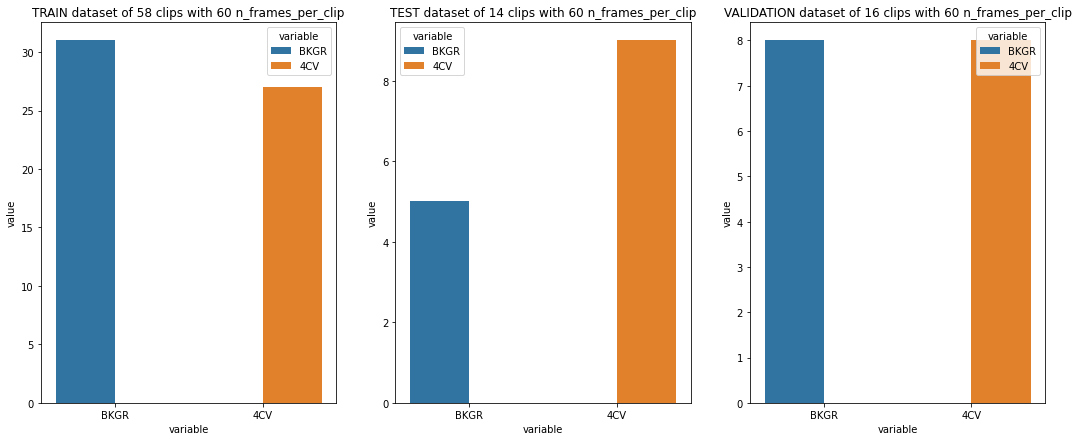

In [3]:
label_id = ('BKGR', '4CV')
number_of_frames_per_segment_in_a_clip = config['number_of_frames_per_segment_in_a_clip'] 

def get_class_distribution(dataset_obj):
    count_class_dict = {
   'BKGR': 0 ,
   "4CV": 0
    }
    
    for clip_index_i in range(len(dataset_obj)):
        data_idx = dataset_obj[clip_index_i]
        label_id_idx = data_idx[1]
        label = label_id[label_id_idx]
        count_class_dict[label]+= 1
        #count_class_dict[label]+= 1* number_of_frames_per_segment_in_a_clip

    return count_class_dict
        
        
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), 
                       x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


print(get_class_distribution(train_set))
print(get_class_distribution(validation_dataset))

plot_title_train_label= f'TRAIN dataset of {len(train_set)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'
plot_title_test_label= f'TEST dataset of {len(test_set)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'
plot_title_val_label= f'VALIDATION dataset of {len(validation_dataset)} clips with {number_of_frames_per_segment_in_a_clip} n_frames_per_clip'

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18,7))
plot_from_dict(get_class_distribution(train_set), plot_title=plot_title_train_label, ax=axes[0])
plot_from_dict(get_class_distribution(test_set), plot_title=plot_title_test_label, ax=axes[1])
plot_from_dict(get_class_distribution(validation_dataset), plot_title=plot_title_val_label, ax=axes[2])
plt.show()



### 2.4 Animating frames of one clip of the dataloader

Clip Size of data_clip_idx torch.Size([60, 1, 128, 128]) of 4CV label


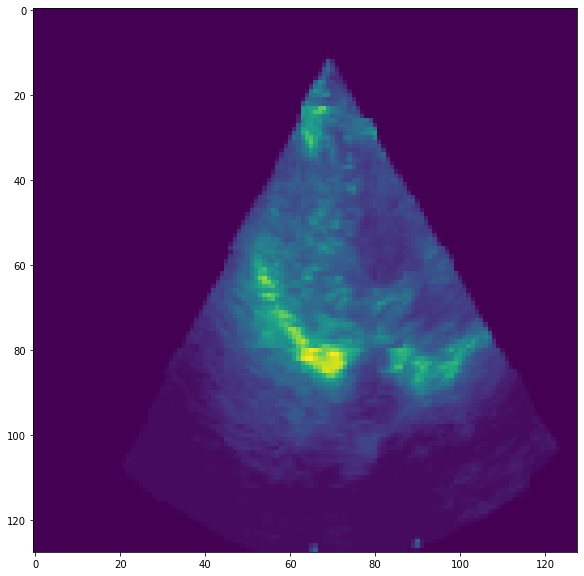

In [4]:
#average_HR =
#fps = 30
# 60 # beats per minute 
#Beats-per-minute: 60 BPM
#Beats-per-second: 1 Hz
#Cycle-per-second: 1 (Cycle/s)

clip_idx = 21
data_clip_idx = train_set[clip_idx][0]
data_clip_label = train_set[clip_idx][1]
print(f'Clip Size of data_clip_idx {data_clip_idx.size()} of {label_id[data_clip_label]} label')

### Animating data_clip_idx 
interval_between_frames_in_milliseconds=200
fig = plt.figure(figsize=(10, 10))
frames = [[plt.imshow(data_clip_idx[i].cpu().detach().numpy().transpose(1, 2, 0))] for i in range(len(data_clip_idx))]
anim = animation.ArtistAnimation(fig, frames, interval=interval_between_frames_in_milliseconds, blit=True, repeat_delay=1000)

HTML(anim.to_jshtml())

# ### Save animation as gif (if required) or other formats https://holypython.com/how-to-save-matplotlib-animations-the-ultimate-guide/
# f = r"/home/mx19/repositories/echocardiography/scripts/learning-pipeline/animation.gif" 
# writergif = animation.PillowWriter(fps=30) 
# writergif2='imagemagick'
# anim.save(f, dpi=80, writer=writergif)


### 2.5 Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
2. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
3. Set the number of clips per batch


In [5]:
##############################
##### Setting up Model Parameters

LEARNING_RATE = 0.000005
MAX_EPOCHS = 10 #Alternatvely, make use of: config['max_epochs']
BATCH_SIZE_OF_CLIPS = 10


model = BasicCNNClassifier(config['pretransform_im_size']) #print(config['pretransform_im_size']) #(128, 128)
model.to(device)


## PRINT MODEL
print(f'====================================================')
print(model)

### PRINT model.named_parameters
print(f'====================================================')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
    
        
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()


BasicCNNClassifier(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=983040, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=2, bias=True)
    (4): Sigmoid()
  )
)
classifier.1.weight tensor([[-1.0829e-04, -9.8747e-04,  7.7940e-04,  ...,  3.7147e-04,
          4.8287e-04, -7.0871e-04],
        [ 5.8732e-04,  1.5710e-04,  1.8768e-04,  ..., -5.2387e-04,
         -6.4399e-04,  7.5010e-05],
        [ 1.6250e-04,  9.8342e-04, -1.5304e-04,  ...,  6.3626e-04,
         -4.9773e-04,  6.3791e-04],
        ...,
        [-2.4954e-04, -3.8347e-04, -8.8051e-04,  ...,  3.4237e-04,
         -8.9797e-04,  1.2411e-04],
        [-1.4878e-04, -3.5682e-05, -7.3577e-04,  ..., -5.2258e-04,
          9.0694e-04,  4.9601e-04],
        [-7.3195e-04, -4.9109e-04, -5.5076e-04,  ..., -6.3635e-04,
         -9.5140e-04, -3.0138e-04]], device='cuda:0')
classifier.1.bias tensor([-1.0363e-04, -5.1167e-04,  9.5607e-04, -4.2357e-05,

### 2.6 Displayting frames in the dataloader

In [6]:
print(f' train_dataset.__len__() = {train_set.__len__()}')
train_dataloader = torch.utils.data.DataLoader(
    train_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)


print(f' test_dataset.__len__() = {test_set.__len__()}')
test_dataloader = torch.utils.data.DataLoader(
    test_set, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)



print(f' validation_dataset.__len__() = {validation_dataset.__len__()}')
val_dataloader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=BATCH_SIZE_OF_CLIPS, 
    shuffle=True, 
    num_workers=0)



for clip_batch_idx, sample_batched in enumerate(train_dataloader):
    print(f'====================================================')
    sample_batched_images=sample_batched[0]
    sample_batched_labels=sample_batched[1]
    print(f'BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
    print(f'SAMPLE_IDX_LABELS: {  sample_batched_labels  }')
    print(f'SAMPLE_BATCH: {sample_batched_images.size()}')
    
    sample_batched=sample_batched_images #.squeeze()
    print(f'SAMPLE_BATCH.squeeze: {sample_batched.size()}')
    
    for BATCH_SIZE_IDX, label in enumerate(sample_batched_labels):
        print(f'   BATCH_SIZE_IDX {BATCH_SIZE_IDX} label: {label}')
        sample_batched_idx_image = sample_batched[BATCH_SIZE_IDX,...]
        print(f'   Sample_batched_idx_image.size()  {sample_batched_idx_image.size() }'  )
        
        grid = utils.make_grid(sample_batched_idx_image)
        print(f'   Grid size {grid.size()}' )
#         plt.figure(figsize =(20,20) )
#         plt.imshow( grid.cpu().detach().numpy().transpose(1, 2, 0) )
#         plt.title(f'BATCH_SIZE_IDX {BATCH_SIZE_IDX}; Label: {label_id[label]}')
#         plt.axis('off')
#         plt.ioff()
#         plt.show()



 train_dataset.__len__() = 58
 test_dataset.__len__() = 14
 validation_dataset.__len__() = 16
BATCH_OF_CLIPS_INDEX: 0 
SAMPLE_IDX_LABELS: tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 1])
SAMPLE_BATCH: torch.Size([10, 60, 1, 128, 128])
SAMPLE_BATCH.squeeze: torch.Size([10, 60, 1, 128, 128])
   BATCH_SIZE_IDX 0 label: 0
   Sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
   BATCH_SIZE_IDX 1 label: 0
   Sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
   BATCH_SIZE_IDX 2 label: 0
   Sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
   BATCH_SIZE_IDX 3 label: 0
   Sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
   BATCH_SIZE_IDX 4 label: 1
   Sample_batched_idx_image.size()  torch.Size([60, 1, 128, 128])
   Grid size torch.Size([3, 1042, 1042])
   BATCH_SIZE_IDX 5 label: 0
   Sample_

### 2.7 Training loop

In [7]:
### TRAINING
#clip_batch_size = tuple(train_dataloader.dataset.__getitem__(0)[0].shape) ##(60, 1, 128, 128) frames, chs, [width, height]
#print(clip_batch_size)


#Dictionaries to store the accuracy/epoch and loss/epoch for both train and validation sets.
loss_stats = {
    'train': [],
    'test': [],
    #"val": []
}
accuracy_stats = {
    #'train': [],
    'test': [],
    #"val": []
}

#for epoch in tqdm(range(1, MAX_EPOCHS)):   
for epoch in range(MAX_EPOCHS):
    print("-" * 10)
    print(f"EPOCH {epoch + 1}/{MAX_EPOCHS}")
    model.train()
    epoch_loss = 0
    step = 0
    
    #train_epoch_loss, train_epoch_acc, val_epoch_loss, val_epoch_acc = train_validation_loop(train_dataloader, val_dataloader, model, criterion, optimizer, device)
    #train_epoch_loss, train_epoch_acc = 
    train_epoch_loss = train_loop(train_dataloader, model, criterion, optimizer, device)
    model.eval()
    test_epoch_loss, correct = test_loop(val_dataloader, model, criterion, device)

    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} | Average Train Acc: {train_epoch_acc:.5f} | Average Validation Loss: {val_epoch_loss:.3f} | Average Validation Acc: {val_epoch_acc:.5f} ')
    #print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} |Average Train Acc: {train_epoch_acc:.5f}  ')
    
    
    #print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_epoch_loss:>8f} \n")

    print(f'Epoch {epoch+0:02}: | Average Train Loss: {train_epoch_loss:.3f} ')
    print(f"Test Error: \n Test Accuracy: {(100*correct):>0.1f}%, Avg Test loss: {test_epoch_loss:>8f} \n")
    
    loss_stats['train'].append(train_epoch_loss)
    loss_stats['test'].append(test_epoch_loss)    
    accuracy_stats['test'].append(100*correct)
            
print("DONE TRAINING LOOP!")



model_path = '/home/mx19/tmp/model' 
print(f' {model_path}')
torch.save(model.state_dict(), os.path.join(model_path, "metric_model.pth"))
print("Saved metric model")


print(loss_stats)
print(accuracy_stats)


----------
EPOCH 1/10
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 00: | Average Train Loss: 0.705 
Test Error: 
 Test Accuracy: 37.5%, Avg Test loss: 0.692392 

----------
EPOCH 2/10
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 01: | Average Train Loss: 0.700 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.697301 

----------
EPOCH 3/10
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_CLIPS_INDEX: 5 
Epoch 02: | Average Train Loss: 0.729 
Test Error: 
 Test Accuracy: 50.0%, Avg Test loss: 0.680674 

----------
EPOCH 4/10
 BATCH_OF_CLIPS_INDEX: 0 
 BATCH_OF_CLIPS_INDEX: 1 
 BATCH_OF_CLIPS_INDEX: 2 
 BATCH_OF_CLIPS_INDEX: 3 
 BATCH_OF_CLIPS_INDEX: 4 
 BATCH_OF_C

## 2.8 Visualize Loss and Accuracy

Text(0.5, 1.0, 'Train-Val Accuracy/Epoch EPOCHS=10 BATCH_SIZE_OF_CLIPS=10 LEARNING_RATE=5e-06')

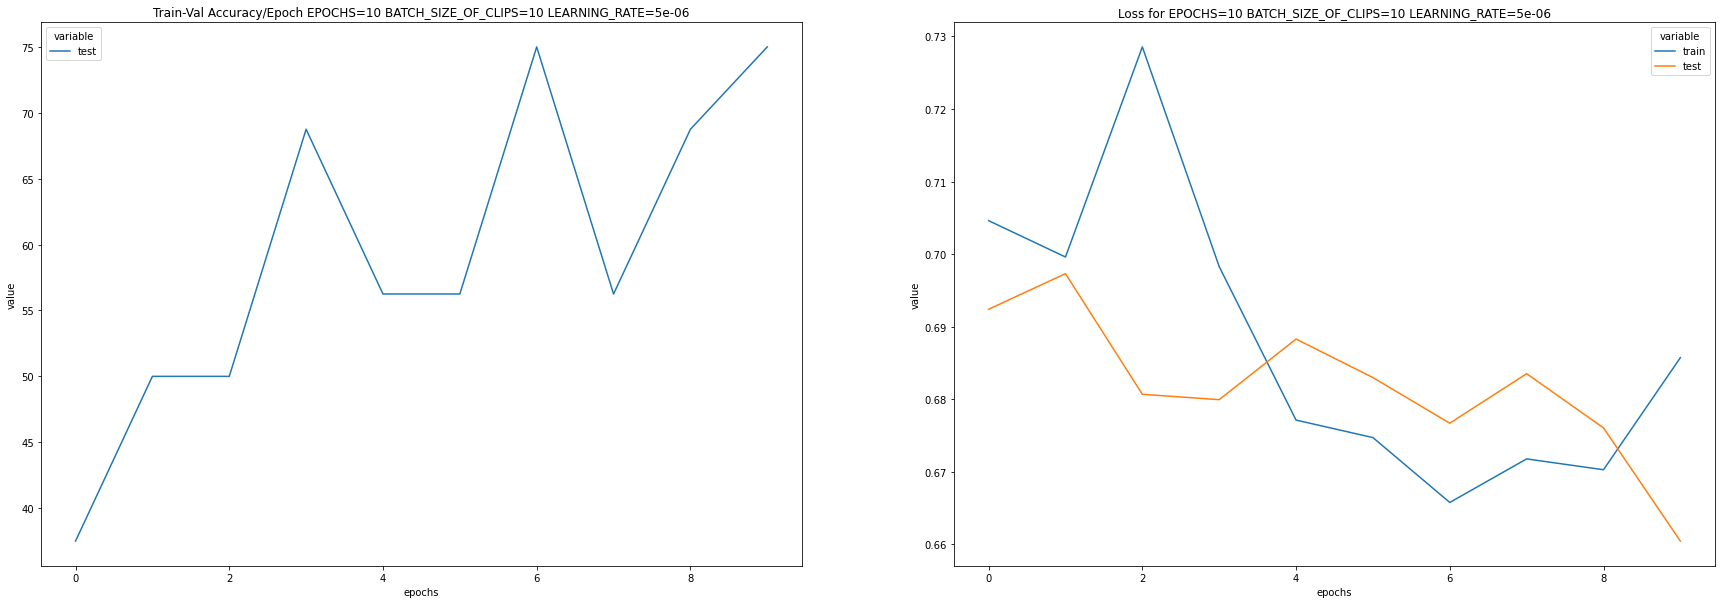

In [8]:

loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})



fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title(f'Loss for EPOCHS={MAX_EPOCHS} BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} LEARNING_RATE={LEARNING_RATE}')
sns.lineplot(data=acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title(f'Train-Val Accuracy/Epoch EPOCHS={MAX_EPOCHS} BATCH_SIZE_OF_CLIPS={BATCH_SIZE_OF_CLIPS} LEARNING_RATE={LEARNING_RATE}')


                     


## 3. Evaluate the model on test dataset

In [9]:
model.load_state_dict(torch.load(
    os.path.join(model_path, "metric_model.pth")))
model.eval()

y_true_list = []
y_pred_list = []

with torch.no_grad():
    for clip_batch_idx, sample_batched in enumerate(test_dataloader):
        X_train_batch, y_train_batch = sample_batched[0].to(device), sample_batched[1].to(device)
        print(f'==================================================')
        print(f' BATCH_OF_CLIPS_INDEX: {clip_batch_idx} ')
        print(f'   X_train_batch.size(): {X_train_batch.size()}') # torch.Size([9, 60, 1, 128, 128]) clips, frames, channels, [width, height]
        print(f'   y_train_batch.size(): {y_train_batch.size()}') # torch.Size([9])

        y_test_pred = model(X_train_batch)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)        
        
        for i in range(len(y_test_pred)):
            y_true_list.append(y_train_batch[i].cpu().item())
            y_pred_list.append(y_pred_tag[i].cpu().item())
            
        
        
print(f'y_pred_list{y_pred_list}')
print(f'y_true_list{y_true_list}')





 BATCH_OF_CLIPS_INDEX: 0 
   X_train_batch.size(): torch.Size([10, 60, 1, 128, 128])
   y_train_batch.size(): torch.Size([10])
 BATCH_OF_CLIPS_INDEX: 1 
   X_train_batch.size(): torch.Size([4, 60, 1, 128, 128])
   y_train_batch.size(): torch.Size([4])
y_pred_list[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]
y_true_list[1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1]


              precision    recall  f1-score   support

           0       0.43      0.60      0.50         5
           1       0.71      0.56      0.63         9

    accuracy                           0.57        14
   macro avg       0.57      0.58      0.56        14
weighted avg       0.61      0.57      0.58        14

[[3 2]
 [4 5]]


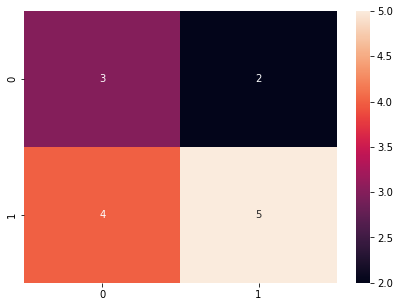

In [10]:

print(classification_report(y_true_list, y_pred_list))
print(confusion_matrix(y_true_list, y_pred_list))

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list))

fig, ax = plt.subplots(figsize=(7,5))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
plt.show()


## Cleanup data directory
Remove directory if a temporary was used.

In [11]:
if model_path is None:
   shutil.rmtree(model_path)
